In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from utils.imports import *
PATH = Path('data/17')
PATH.mkdir(exist_ok=True)
path_x_512 = PATH/'preprocessed'/'2017B'
path_y_512 = PATH/'preprocessed'/'b-class'
path_test_x_512 = PATH/'preprocessed'/'2017B'
path_stats = PATH/'preprocessed'/'2017B'/'stats.npy'

sz = 512
test_size = 0.2
gpu_start = 7
world_size = 1
bs = world_size * 20
num_workers = 4

In [3]:
%run train_17 {str(path_x_512)} {str(path_y_512)} {str(PATH)} {str(path_stats)}\
    {bs} {sz} {gpu_start} --world_size={world_size} --path_test_x={path_test_x_512} --path_test_y={path_y_512}

## Look at the data

In [4]:
dl = iter(learner.data.val_dl)

In [5]:
x, y = next(dl)

In [6]:
print(x.shape, y.shape)
dx, dy = denorm(x), denorm(y, is_y=True)
print(x.shape, y.shape)

torch.Size([20, 3, 512, 512]) torch.Size([20, 512, 512])
torch.Size([20, 3, 512, 512]) torch.Size([20, 512, 512])


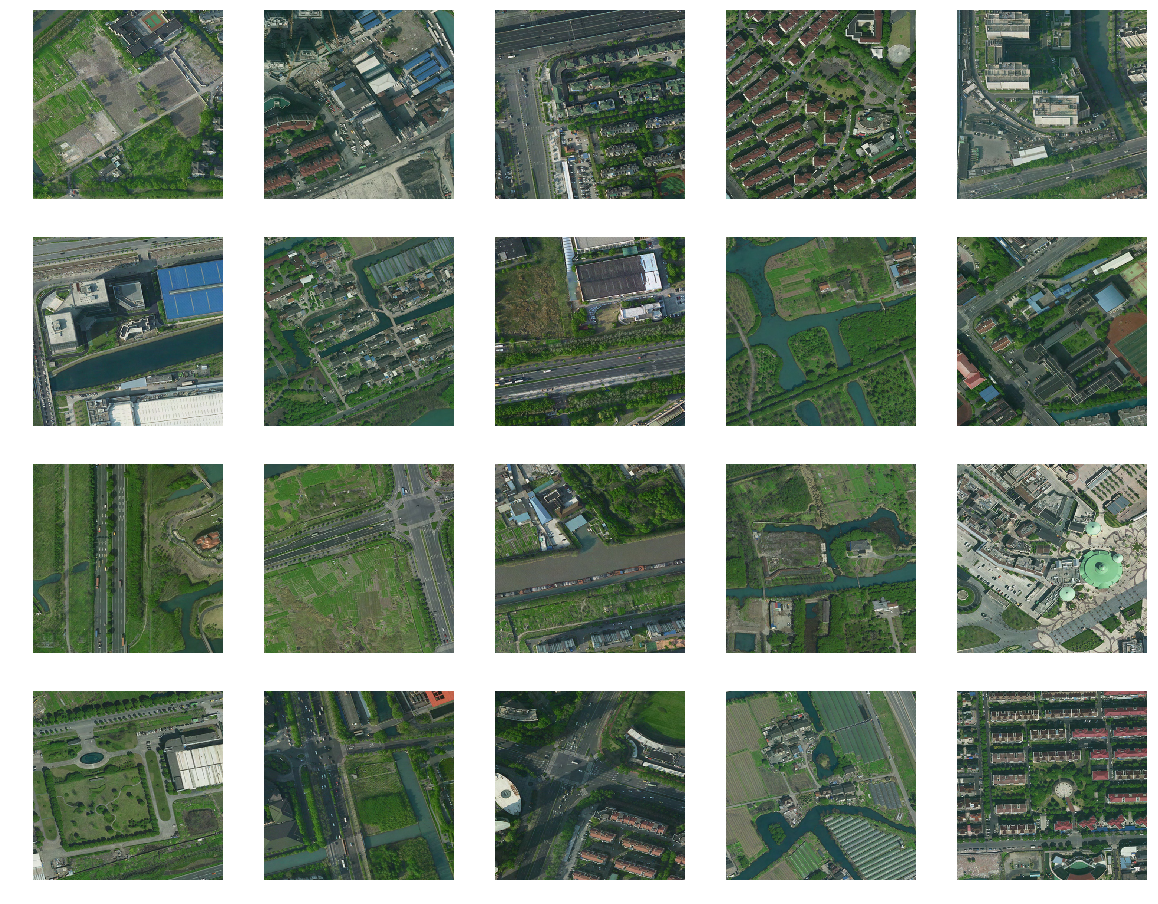

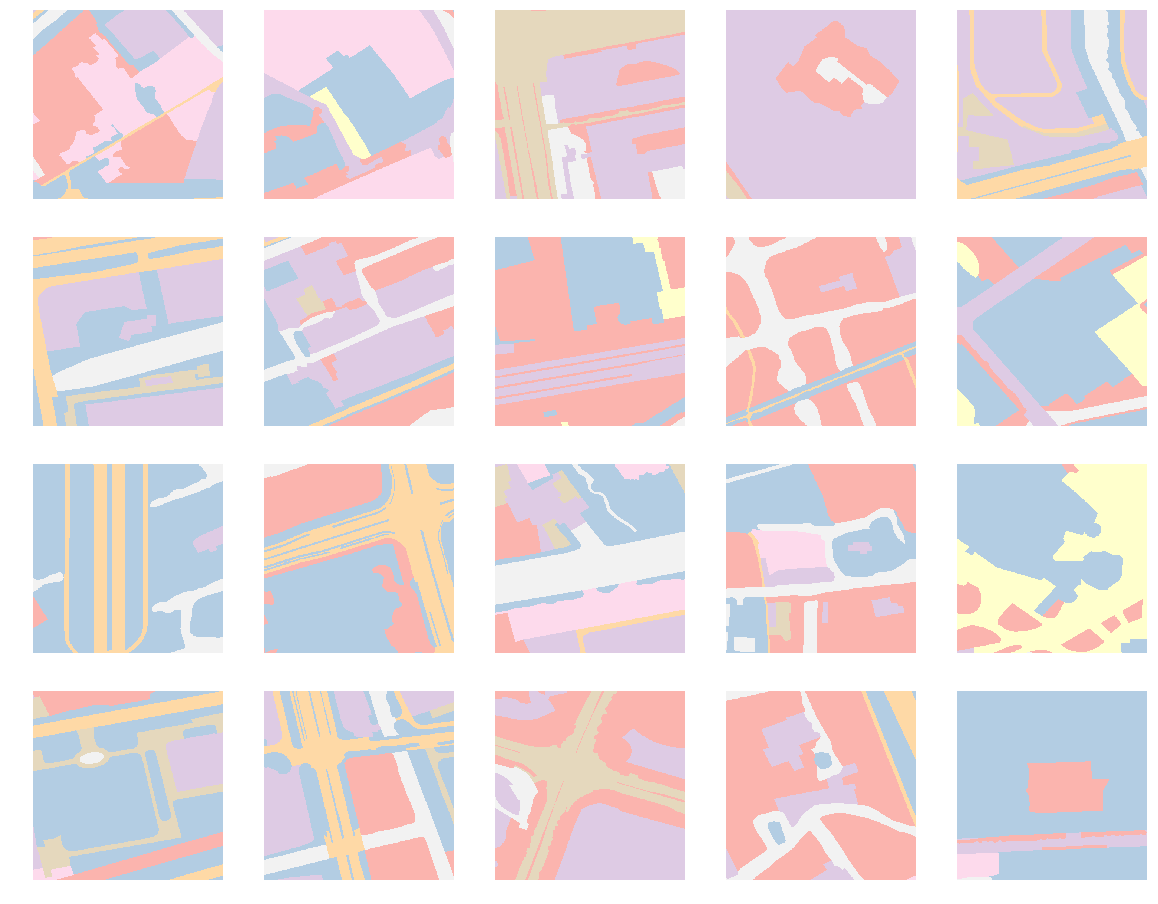

In [13]:
# idx = np.random.permutation(bs)[:8]
idx = range(bs)
data_x, data_y = dx[idx], dy[idx]
plots(data_x, figsize=(20, 16), rows=4)
plots(data_y, figsize=(20, 16), rows=4, cmap='Pastel1')

## Load model

In [4]:
device_ids = range(gpu_start, gpu_start + world_size)
learner.models.model = DataParallel(learner.models.model, device_ids)

In [5]:
fn_weights = 'data/17/models/4_long_run_cyc_0.h5'
load_model(learner.model, fn_weights)

### load 18

In [6]:
md17 = learner.data

In [7]:
path_x_512_18 = PATH/'preprocessed'/'2018B'
stats = np.load(path_stats)
md18, _ = get_loader(PATH, path_x_512_18, path_y_512, stats, bs, sz, gpu_start, path_test_x=path_x_512_18, path_test_y=path_y_512)
iter17 = iter(md17.test_dl)
iter18 = iter(md18.test_dl)

In [10]:
batch_17, y = next(iter17)
batch_18, _ = next(iter18)
denormed_batch_17, denormed_batch_18 = denorm(batch_17), denorm(batch_18)

In [9]:
pred_17, pred_18 = predict_tensor(learner, batch_17), predict_tensor(learner, batch_18)
c_17, c_18 = np.argmax(pred_17, axis=1), np.argmax(pred_18, axis=1)

In [69]:
p_diff = pred_18 - pred_17
same_c = c_17 != c_18
p_diff_th5 = p_diff.copy(); p_diff_th5[p_diff < 0.5] = 0; c_diff_th5 = np.argmax(p_diff_th5, axis=1)
p_diff_th2 = p_diff.copy(); p_diff_th2[p_diff < 0.2] = 0; c_diff_th2 = np.argmax(p_diff_th2, axis=1)

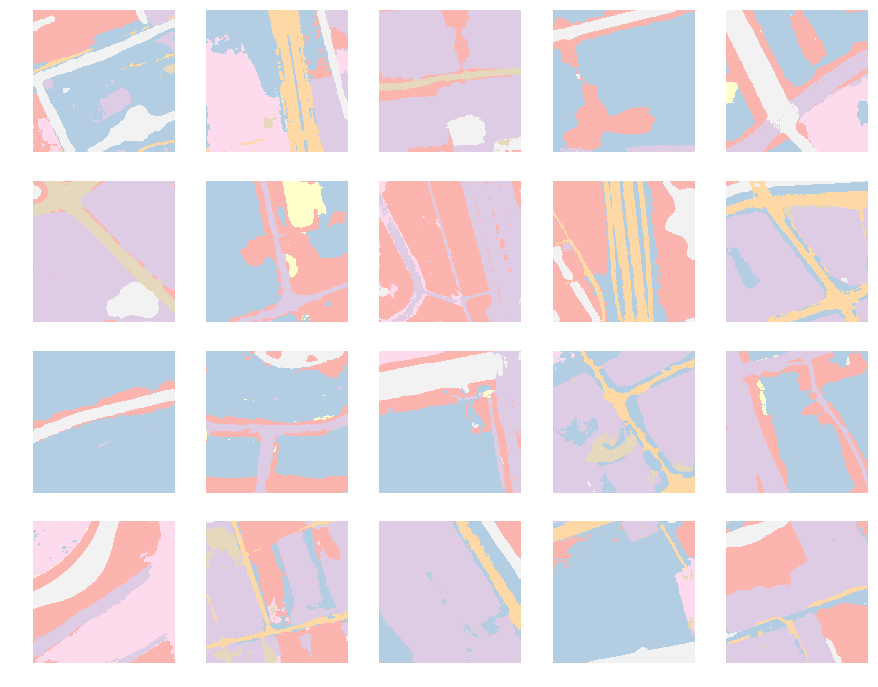

In [80]:
plots(c_17, rows=4, cmap='Pastel1')

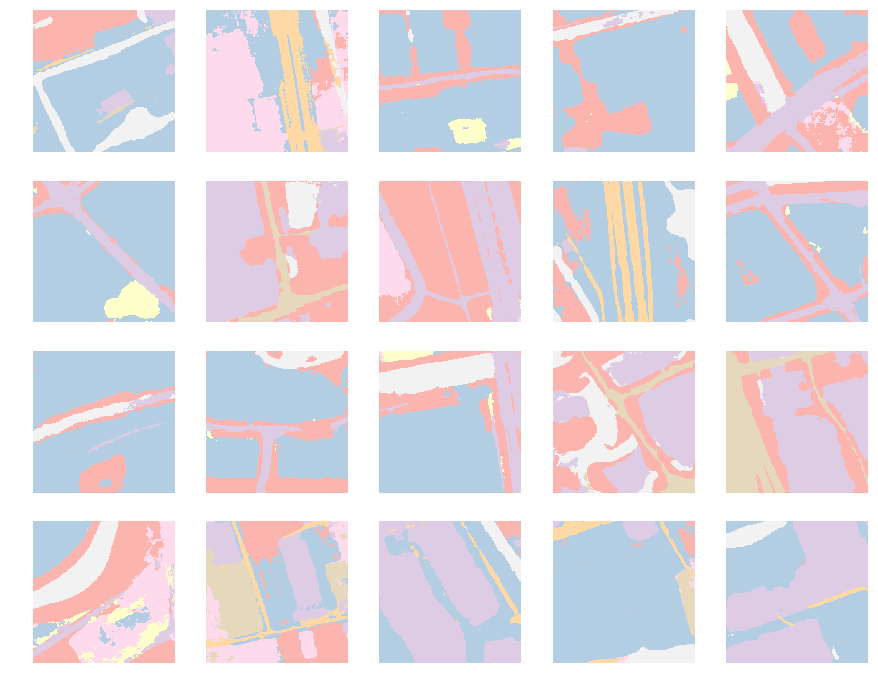

In [81]:
plots(c_18, rows=4, cmap='Pastel1')

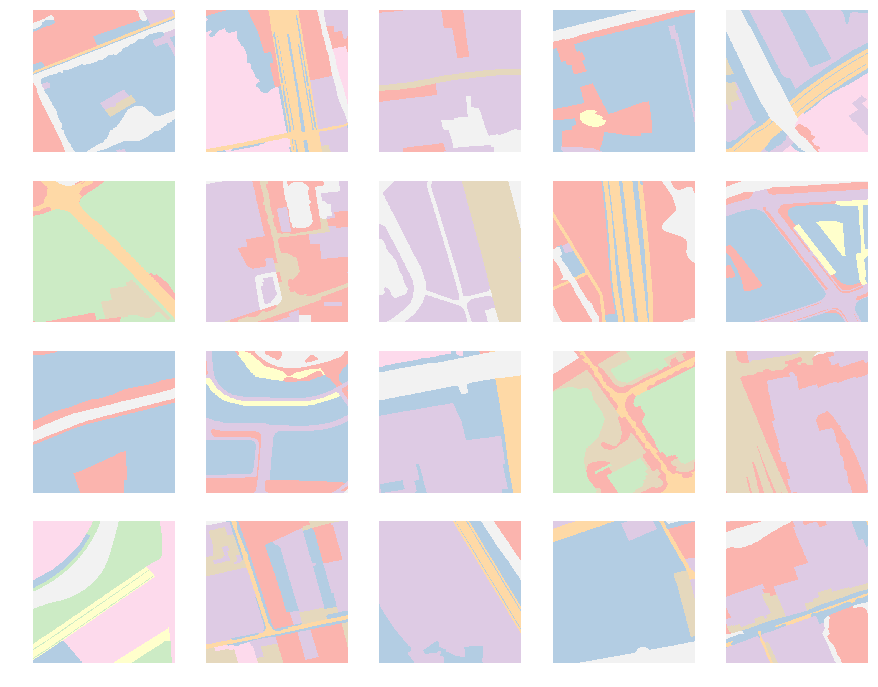

In [82]:
plots(y, rows=4, cmap='Pastel1')

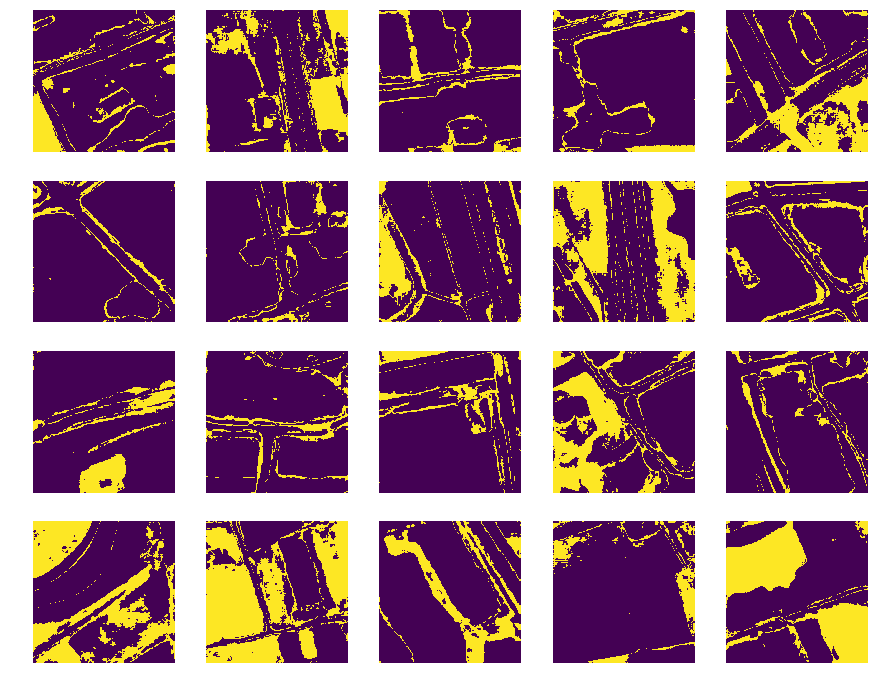

In [70]:
plots(same_c, rows=4)

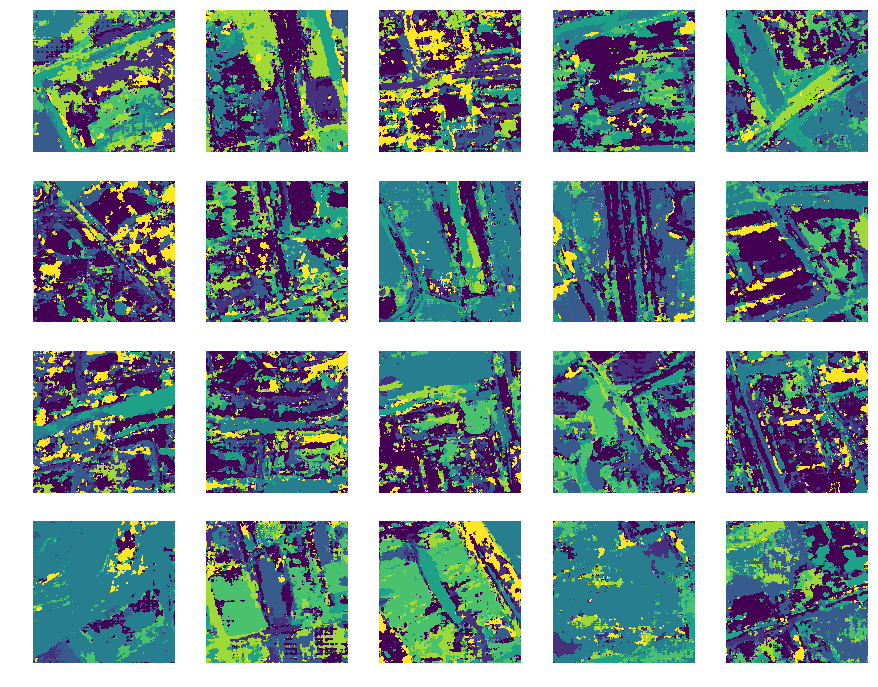

In [55]:
plots(c_diff_th5, rows=4)

ratio of same class

In [71]:
num_pixels = c_diff.size
num_zeros = np.sum(same_c == 0)
ratio = num_zeros / num_pixels
ratio

0.803585433959961

inversely sort by ratio of zero

In [60]:
zeros = np.array([np.sum(o == 0) for o in same_c])

In [61]:
sort_indecies = np.argsort(zeros)
zeros[sort_indecies]

array([ 15840,  18622,  23928,  24168,  25668,  26627,  27294,  30509,  36395,  36553,  38709,  40606,
        48871,  65864,  66445,  76895,  89075,  95198, 105525, 136986])

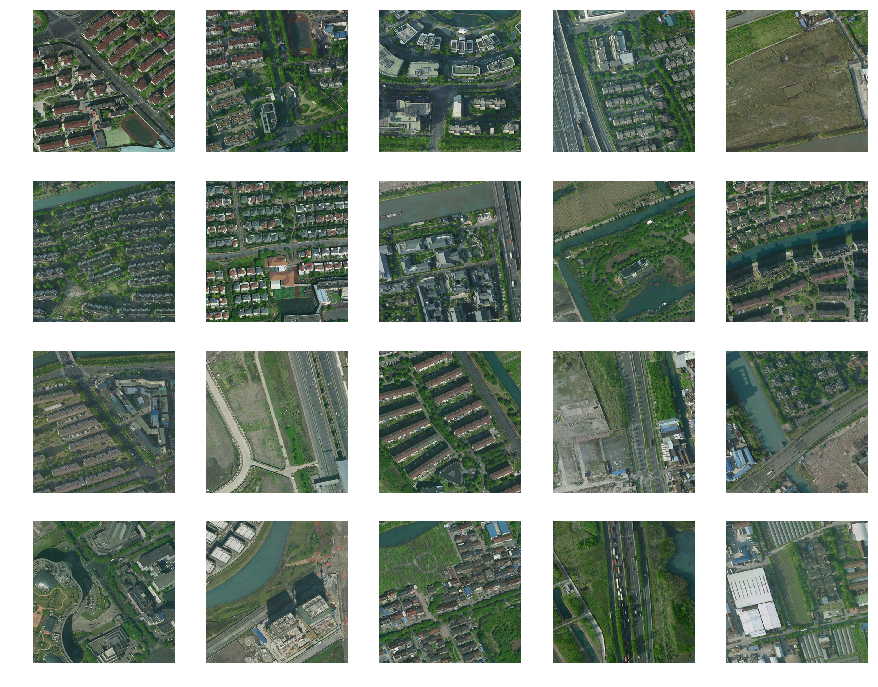

In [62]:
plots(denormed_batch_17[sort_indecies])

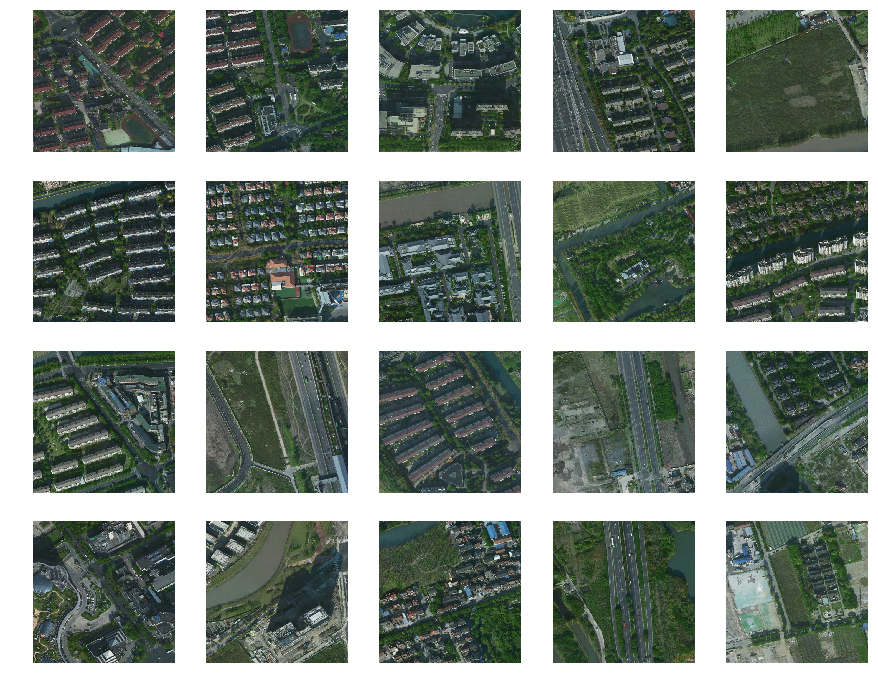

In [63]:
plots(denormed_batch_18[sort_indecies])

In [37]:
alpha = 0.7
def alpha_blend(x, y, alpha=0.5):
    if len(y.shape) > len(x.shape):
        x, y = y, x
        alpha = 1 - alpha
    if len(y.shape) < len(x.shape): y = y[...,None]
    ret = np.copy(x * alpha)
    ret += y * (1 - alpha)
    return ret

In [ ]:
blended_17 = alpha_blend(denormed_batch_17[sort_indecies], same_c[sort_indecies], alpha)
plots(blended_17, size=14)

In [ ]:
blended_18 = alpha_blend(denormed_batch_18[sort_indecies], same_c[sort_indecies], alpha)
plots(blended_18, size=14)

In [85]:
different_p = np.abs(pred_17 - pred_18)
different_p.shape

(20, 8, 512, 512)

In [102]:
different_p_from = pred_17 - pred_18
different_p_to = -different_p_from
im_different_p = np.sum(np.abs(different_p_from), axis=(-1, -2))
im_most_prominent_c = np.argmax(im_different_p, axis=1)
im_most_prominent_c

array([4, 3, 0, 0, 5, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 5, 3, 1])

## Test data

In [8]:
from baseline_direct_subtraction import *
names = [o.split('/')[-1][5:-4] for o in md17.test_ds.fn_x]
save_path_17 = PATH/'baseline_direct_subtraction/17_8ch'
save_path_17.mkdir(exist_ok=True)
save_path_18 = PATH/'baseline_direct_subtraction/18_8ch'
save_path_18.mkdir(exist_ok=True)

pickle predictions to disk

In [10]:
%%time
save_preds(learner, md17.test_dl, save_path_17, names, num_workers=40)

waiting for writing to disk
CPU times: user 34min 37s, sys: 2min 48s, total: 37min 26s
Wall time: 1min 18s


In [9]:
%%time
save_preds(learner, md18.test_dl, save_path_18, names, num_workers=80)

waiting for writing to disk
CPU times: user 33min 43s, sys: 3min 22s, total: 37min 5s
Wall time: 1min 36s


In [9]:
fns1, fns2 = sorted(save_path_17.glob('*.npz')), sorted(save_path_18.glob('*.npz'))

In [10]:
overlap_rank = rank_overlap(fns1, fns2)

KeyboardInterrupt: 

In [ ]:
tqdm_notebook()